# Assignment 1 - Data Analytics

Basilisco, Farah Jane & Bonachita, Clybel Djen

---

### Key Procedures (Balaned Risk Set Matching)

- The script loads patient data, calculates Mahalanobis distances, and applies optimal risk set matching.
- Uses the Hungarian algorithm (linear sum assignment) for optimal pair matching.
- Implements Wilcoxon signed-rank test for sensitivity analysis.
- Can be expanded with network flow optimization for larger datasets

### Python Implementation

CSV file 'patient_data.csv' created successfully!
Wilcoxon Test Statistic: 0.0, P-value: 0.045500263896358396


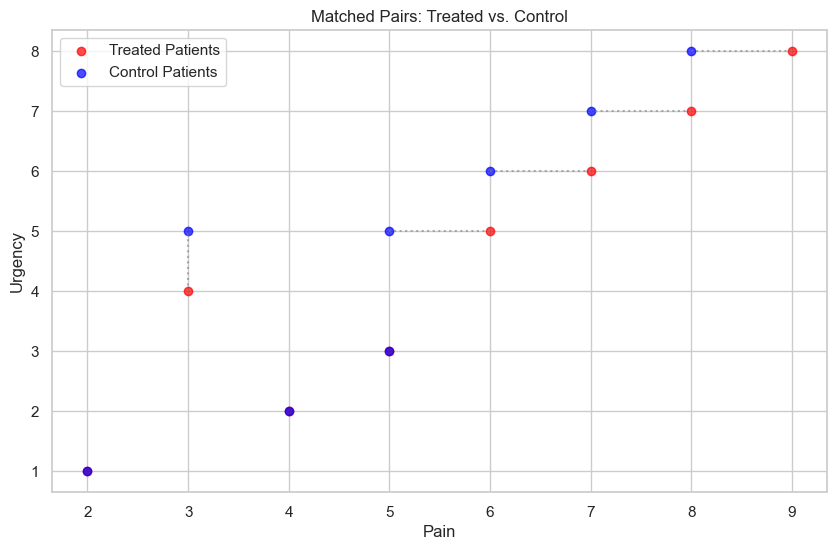

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from scipy.stats import wilcoxon

warnings.simplefilter("ignore", UserWarning)

# Step 1: Generate Sample Data
def create_sample_csv():
    """Creates a sample dataset and saves it as patient_data.csv."""
    data = {
        "patient_id": range(1, 17),
        "treated": [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
        "pain": [3, 3, 7, 6, 5, 5, 8, 7, 4, 4, 6, 5, 9, 8, 2, 2],
        "urgency": [4, 5, 6, 6, 3, 3, 7, 7, 2, 2, 5, 5, 8, 8, 1, 1],
        "frequency": [2, 2, 4, 4, 3, 3, 5, 5, 2, 2, 3, 3, 6, 6, 1, 1],
        "post_treatment_pain": [2, 3, 5, 5, 3, 4, 6, 6, 2, 3, 4, 4, 7, 7, 1, 2]
    }

    df = pd.DataFrame(data)
    df.to_csv("patient_data.csv", index=False)
    print("CSV file 'patient_data.csv' created successfully!")

# Step 2: Load Data
def load_data(file_path):
    """Loads patient data from CSV."""
    try:
        data = pd.read_csv(file_path)
        required_columns = {"patient_id", "treated", "pain", "urgency", "frequency", "post_treatment_pain"}
        if not required_columns.issubset(data.columns):
            raise ValueError(f"CSV file is missing required columns: {required_columns - set(data.columns)}")
        return data
    except Exception as e:
        print(f"Error loading CSV: {e}")
        exit(1)

# Step 3: Compute Mahalanobis Distance
def compute_distance_matrix(data, symptom_cols):
    """Computes Mahalanobis distance between patients based on symptoms."""
    symptoms = data[symptom_cols].values
    cov_matrix = np.cov(symptoms.T)
    inv_cov = np.linalg.pinv(cov_matrix)  # Use pseudo-inverse for stability
    return cdist(symptoms, symptoms, metric='mahalanobis', VI=inv_cov)

# Step 4: Match Patients Using Hungarian Algorithm
def match_patients(data, treatment_col, symptom_cols):
    """Matches treated and control patients optimally."""
    treated = data[data[treatment_col] == 1].reset_index(drop=True)
    control = data[data[treatment_col] == 0].reset_index(drop=True)

    if treated.empty or control.empty:
        print("Error: No treated or control patients found in the dataset.")
        exit(1)

    distance_matrix = compute_distance_matrix(data, symptom_cols)
    
    treated_idx = treated.index.values
    control_idx = control.index.values
    cost_matrix = distance_matrix[np.ix_(treated_idx, control_idx)]

    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    matches = [(treated.iloc[i]["patient_id"], control.iloc[j]["patient_id"]) for i, j in zip(row_ind, col_ind)]
    
    return matches

# Step 5: Perform Wilcoxon Signed-Rank Test
def sensitivity_analysis(matches, data, outcome_col):
    """Performs Wilcoxon signed-rank test to compare matched pairs."""
    treated_outcomes = [data.loc[data["patient_id"] == t, outcome_col].values[0] for t, c in matches]
    control_outcomes = [data.loc[data["patient_id"] == c, outcome_col].values[0] for t, c in matches]

    if len(treated_outcomes) != len(control_outcomes):
        print("Error: Mismatch in treated and control patient outcome data.")
        exit(1)

    stat, p_value = wilcoxon(treated_outcomes, control_outcomes)
    return stat, p_value

# Step 6: Visualize Matched Pairs
def plot_matched_pairs(matches, data, symptom_x="pain", symptom_y="urgency"):
    """Visualizes matched pairs in a scatter plot."""
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")

    treated_x, treated_y, control_x, control_y = [], [], [], []

    for t, c in matches:
        t_data = data[data["patient_id"] == t]
        c_data = data[data["patient_id"] == c]

        if t_data.empty or c_data.empty:
            continue

        treated_x.append(t_data[symptom_x].values[0])
        treated_y.append(t_data[symptom_y].values[0])
        control_x.append(c_data[symptom_x].values[0])
        control_y.append(c_data[symptom_y].values[0])

        plt.plot([treated_x[-1], control_x[-1]], [treated_y[-1], control_y[-1]], 
                 'gray', linestyle="dotted", alpha=0.6)

    plt.scatter(treated_x, treated_y, color='red', label="Treated Patients", alpha=0.7)
    plt.scatter(control_x, control_y, color='blue', label="Control Patients", alpha=0.7)

    plt.xlabel(symptom_x.capitalize())
    plt.ylabel(symptom_y.capitalize())
    plt.title("Matched Pairs: Treated vs. Control")
    plt.legend()
    plt.show()

# Step 7: Run the Full Script
if __name__ == "__main__":
    # Generate Sample Data
    create_sample_csv()

    # Load Data
    file_path = "patient_data.csv"
    data = load_data(file_path)
    symptom_cols = ["pain", "urgency", "frequency"]

    # Perform Matching
    matches = match_patients(data, treatment_col="treated", symptom_cols=symptom_cols)

    # Perform Sensitivity Analysis
    stat, p_value = sensitivity_analysis(matches, data, outcome_col="post_treatment_pain")
    print(f"Wilcoxon Test Statistic: {stat}, P-value: {p_value}")

    # Plot Matched Pairs
    plot_matched_pairs(matches, data, symptom_x="pain", symptom_y="urgency")
